In [1]:
path_to_gpt3 = 'target/hotel_Cleanliness.gold_att.train'
path_to_gold = 'target/hotel_Cleanliness.gold_att.train'
path_to_pred = 'target/hotel_Cleanliness.pred_att.train'

In [2]:
import pandas as pd
from ast import literal_eval
import torch
import torch.nn as nn

In [3]:
def load_rat_pred_gold(path, task, regression):
    '''
    path: path to the tsv file which contains label, text, oracle attention, rationale and R2A
    generated attention
    task: the name of the task
    regression: a binary variable indicating whether we are doing classification or regression
    '''
    print(task)
    df = pd.read_csv(path ,encoding='latin-1')

    data = []

    for row in df.itertuples(index=False):

        # Only collect examples for this aspect
        if task != row.task.strip():
            print("stripping example for this aspect")
            continue

        text = row.text.replace('  ',' ').split(' ')
        rationale = [0 for i in range(len(text))]
        pred_att  = [0 for i in range(len(text))]
        gold_att  = [0 for i in range(len(text))]
        # print(len(row))
        if len(row) > 3:
            rationale = literal_eval(row.gpt3_rationale)
        
        # TODO the following 2 prob need literal_eval or smth
        if len(row) > 4:
            pred_att = [float(x) for x in row[4].strip().split(' ')]
        if len(row) > 5:
            gold_att = [float(x) for x in row[5].strip().split(' ')]

        data.append({
            'text'     : text, 
            'label'    : float(row.label) if regression else int(float(row.label)),
            'rationale': rationale,
            'gold_att' : gold_att,
            'pred_att' : pred_att,
            })

    return data

In [4]:
def load_rat_pred_gold_orig(path, task, regression):
    '''
    path: path to the tsv file which contains label, text, oracle attention, rationale and R2A
    generated attention
    task: the name of the task
    regression: a binary variable indicating whether we are doing classification or regression
    '''
    with open(path, 'r') as f:
        next(f)
        data = []

        for row in f:
            row = row.strip().split('\t')

            # Only collect examples for this aspect
            if task != row[0].strip():
                continue

            text = row[2].replace('  ',' ').split(' ')
            rationale = [0 for i in range(len(text))]
            pred_att  = [0 for i in range(len(text))]
            gold_att  = [0 for i in range(len(text))]

            if len(row) > 3:
                rationale = [round(float(x)) for x in row[3].strip().split(' ')]
            if len(row) > 4:
                pred_att = [float(x) for x in row[4].strip().split(' ')]
            if len(row) > 5:
                gold_att = [float(x) for x in row[5].strip().split(' ')]

            data.append({
                'text'     : text, 
                'label'    : float(row[1]),
                'rationale': rationale,
                'gold_att' : gold_att,
                'pred_att' : pred_att,
                })

    return data

In [5]:
data_gpt3 = load_rat_pred_gold_orig(path_to_gpt3, 'hotel_Cleanliness', False)

rationales_gpt3 = []
for el in data_gpt3:
    # Normalize rationales to bring them to same scale as attention
    rationale_tensor = torch.tensor(el['rationale'], dtype=torch.float)
    rationale_tensor = rationale_tensor/torch.sum(rationale_tensor)
    rationales_gpt3.append(rationale_tensor)

In [6]:
data_gold = load_rat_pred_gold_orig(path_to_gold, 'hotel_Cleanliness', False)

attentions_gold = []
for el in data_gold:
    attentions_gold.append(torch.tensor(el['gold_att'], dtype=torch.float))

In [7]:
data_pred = load_rat_pred_gold_orig(path_to_pred, 'hotel_Cleanliness', False)
attentions_pred = []
for el in data_pred:
    attentions_pred.append(torch.tensor(el['pred_att'], dtype=torch.float))

In [8]:
# loss = nn.MSELoss()
loss = nn.KLDivLoss()

for i in range(len(rationales_gpt3)):    
    # KLDivLoss takes input in log space
    gold_loss = (loss(torch.log(attentions_gold[i]), rationales_gpt3[i]))
    pred_loss = (loss(torch.log(attentions_pred[i]), rationales_gpt3[i]))
    # print(gold_loss)
    # print(pred_loss)
    if pred_loss <= gold_loss + 0.0001:
        print(i)
        # print(attentions_gold)
        print()

130

133

179



In [9]:
# loss = nn.MSELoss()

# for i in range(len(rationales_human)):    
#     gold_loss = (loss(attentions_gold[i], rationales_human[i]))
#     pred_loss = (loss(attentions_pred[i], rationales_human[i]))
#     print(gold_loss*1000)
#     print(pred_loss*1000)
#     # if pred_loss <= gold_loss + 0.0001:
#         # print(i)
#     print()

In [10]:
# load gpt-3 rationales
df_hotel_full = pd.read_csv('hotel_FINAL.csv', encoding='latin-1')

In [11]:
df_hotel_full.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'task', 'label', 'text', 'rationale',
       'pred_att', 'gold_att', 'rat_frequency', 'split_text',
       'gpt3_rationales_raw', 'gpt3_rationales_cleaned', 'gpt3_rationale',
       'gpt3_rationales_raw_2', 'gpt3_rationales_cleaned_2'],
      dtype='object')

In [12]:
rationales_standard = []

for row in df_hotel_full.itertuples():
    rationale_val = literal_eval(row.rationale)
    rationale_tensor = torch.tensor(rationale_val, dtype=torch.float)
    rationale_tensor = rationale_tensor/torch.sum(rationale_tensor)
    rationales_standard.append(rationale_tensor)

In [16]:
loss = nn.KLDivLoss()

best_idx = None
best_diff = 0

for i in range(len(rationales_standard)):    
    # KLDivLoss takes input in log space
    gold_loss = (loss(torch.log(attentions_gold[i]), rationales_standard[i]))
    pred_loss = (loss(torch.log(attentions_pred[i]), rationales_standard[i]))
    if gold_loss - pred_loss >= best_diff:
        best_idx = i
        best_diff = gold_loss - pred_loss

print(best_idx, best_diff)

23 tensor(0.0129)


In [25]:
best_gold = attentions_gold[best_idx].numpy()
best_pred = attentions_pred[best_idx].numpy()
best_rat = rationales_standard[best_idx].numpy()

In [22]:
import matplotlib.pyplot as plt

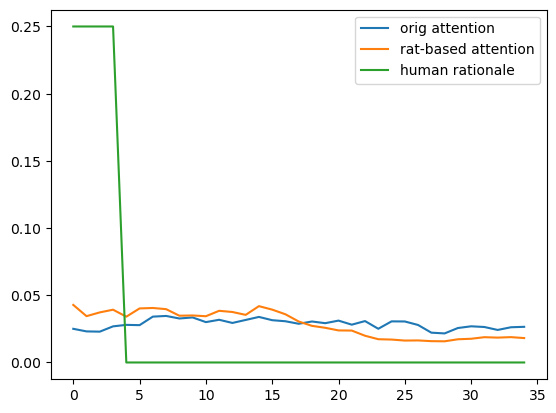

In [36]:
plt.plot(best_gold, label='orig attention')
plt.plot(best_pred, label='rat-based attention')
plt.plot(best_rat, label='human rationale')
plt.legend()

In [39]:
best_pred

array([0.04283196, 0.03446583, 0.03726208, 0.03926581, 0.03408082,
       0.04021595, 0.04055145, 0.0396756 , 0.03479188, 0.03497623,
       0.03441609, 0.03845121, 0.03755801, 0.03542202, 0.04191559,
       0.03932069, 0.03584896, 0.03047368, 0.02724713, 0.02580532,
       0.02385166, 0.02373719, 0.01989441, 0.01730809, 0.01705074,
       0.01630894, 0.01640119, 0.01586462, 0.015757  , 0.01725925,
       0.01764949, 0.01881588, 0.01850393, 0.01885855, 0.01816268],
      dtype=float32)